In [1]:
# Creating label file
import json
di = {
        "0":"Arts & Photography",
        "1":"Biographies & Memoirs",
        "2":"Business & Money",
        "3":"Calendars",
        "4":"Children's Books",
        "5":"Comics & Graphic Novels",
        "6":"Computers & Technology",
        "7":"Cookbooks, Food & Wine",
        "8":"Crafts, Hobbies & Home",
        "9":"Christian Books & Bibles",
        "10":"Engineering & Transportation",
        "11":"Health, Fitness & Dieting",
        "12":"History",
        "13":"Humor & Entertainment",
        "14":"Law",
        "15":"Literature & Fiction",
        "16":"Medical Books",
        "17":"Mystery, Thriller & Suspense",
        "18":"Parenting & Relationships",
        "19":"Politics & Social Sciences",
        "20":"Reference",
        "21":"Religion & Spirituality",
        "22":"Romance",
        "23":"Science & Math",
        "24":"Science Fiction & Fantasy",
        "25":"Self-Help",
        "26":"Sports & Outdoors",
        "27":"Teen & Young Adult",
        "28":"Test Preparation",
        "29":"Travel"
}

with open('cat_to_name.json', 'w') as file:
    json.dump(di,file)

In [2]:
!jupyter nbconvert --to html '__notebook_source__.ipynb' /kaggle/working/output.html

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] WARNING | pattern '/kaggle/working/output.html' matched no files
[NbConvertApp] Converting notebook __notebook_source__.ipynb to html
[NbConvertApp] Writing 573607 bytes to __notebook_source__.html


In [3]:
import os
# os.chdir('')
os.listdir()

['cat_to_name.json',
 '__notebook_source__.html',
 '__notebook_source__.ipynb',
 'checkpoints',
 '.virtual_documents']

In [4]:
#!mkdir checkpoints

In [5]:
import os
import shutil
import random

# Read and process the TEST labels
with open('/kaggle/input/bookset/Data Set/Task/bookcover30-labels-test.txt', 'r') as f:
    test_labels = [line.split() for line in f]

src = '/kaggle/input/amazonbookimage/224x224'
dest = '/kaggle/working/checkpoints/v'
for label in test_labels:
    image_name, label_id = label[0], label[1]
    label_dir = os.path.join(dest, label_id)

    os.makedirs(label_dir, exist_ok=True)  # Create label directory if it doesn't exist

    shutil.copy(os.path.join(src, image_name), os.path.join(label_dir, image_name))

# Read and process the TRAIN labels
with open('/kaggle/input/bookset/Data Set/Task/bookcover30-labels-train.txt', 'r') as f:
    train_labels = [line.split() for line in f]

dest = '/kaggle/working/checkpoints/t'

for label in train_labels:
    image_name, label_id = label[0], label[1]
    label_dir = os.path.join(dest, label_id)

    os.makedirs(label_dir, exist_ok=True)  # Create label directory if it doesn't exist

    shutil.copy(os.path.join(src, image_name), os.path.join(label_dir, image_name))


In [6]:
# !unzip  images.zip -d .

In [7]:
import os
import torch
# import torch_xla
# import torch_xla.core.xla_model as xm
from torch import nn, optim
 # from torchvision import datasets,transforms,models
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

In [8]:
import time

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

cuda:0


In [10]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [11]:

data_path  = 'CSV'
train_path =  '/kaggle/working/checkpoints/t'
test_path =  '/kaggle/working/checkpoints/t'
valid_path =  '/kaggle/working/checkpoints/v'
print(os.path.isdir(valid_path))

True


data_path  = 'CSV'
train_path =  '/kaggle/input/vaildationofbook/Train'
test_path =  '/kaggle/input/vaildationofbook/Valid'
valid_path =  '/kaggle/input/amazonbookimage/224x224'
print(os.path.isdir(valid_path))

In [12]:
import torch
import torchvision
from torchvision import datasets, transforms

In [13]:
#as images are already 224x224 no need to crop or resize
data_transforms = {
    'Train':    transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
#               transforms.RandomRotation(degrees=180),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
                transforms.CenterCrop(224), 
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])  
    ])   
}


In [14]:
train_data = datasets.ImageFolder(train_path,transform = data_transforms['Train'])
valid_data = datasets.ImageFolder(valid_path,transform = data_transforms['test'])
test_data = datasets.ImageFolder(test_path, transform= data_transforms['test'])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(valid_data,batch_size=32,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=True,num_workers=2)


In [15]:
def build_model():
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088,1024)),
        ('relu', nn.ReLU()),
        ('dropout',nn.Dropout(0.1)),
        ('fc2', nn.Linear(1024, 30)),
        ('output', nn.LogSoftmax(dim=1))
    ])) 
    
    model.classifier = classifier
    return model


In [16]:
from torchvision import models
model = build_model()
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 253MB/s] 


In [17]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.0005)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [19]:
# Validation function

def validation(model,data,criterian):
    model.eval()
#     model.to(device)
    accuracy = 0
    loss = 0

    for images,labels in data:

        images,labels = images.to(device),labels.to(device)
        output = model.forward(images)
        loss+= criterian(output,labels).item()

        ps = torch.exp(output)
        eq = (labels.data == ps.max(dim=1)[1])
        accuracy += eq.type(torch.FloatTensor).mean()

    return accuracy,loss

In [20]:
valid = []
running = []
def trainer(model,train_data,criterion,optimizer,valid_data,epoch=5):
    running_loss = 0
    print(device)
    # Using GPU/TPU if available else CPU
#     model.to(device)

    for i in range(epoch):
        model.train()
        for loop ,(inputs, labels) in enumerate(train_data):
            
            loop = loop+1
            inputs,labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            #Forwarding and BackPropagating

            output = model.forward(inputs)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
#             xm.mark_step()

            running_loss += loss.item()

            #defining statistics

            if loop % 256 == 0:

            # Evaluation Mode
                model.eval()
                
                with torch.no_grad():
                    accuracy,validation_loss = validation(model,valid_data,criterion)
                
                print("Epoch: {}/{} ".format(i+1,epoch),
                     "Running Loss: {:.3f}".format(running_loss/256),
                     "Validation Loss: {:.3f}".format(validation_loss/len(valid_data)),
                     "Validation Accuracy: {:.2f} %".format((accuracy/len(valid_data))*100)  
                     )
                running.append(running_loss/256)
                valid.append(validation_loss/len(valid_data))
                running_loss = 0

                # Training mode
                model.train()

In [21]:
epochs=5

In [22]:
trainer(model,trainloader,criterion,optimizer,validloader,epochs)

cuda:0
Epoch: 1/5  Running Loss: 3.105 Validation Loss: 2.941 Validation Accuracy: 19.20 %
Epoch: 1/5  Running Loss: 2.947 Validation Loss: 2.859 Validation Accuracy: 21.49 %
Epoch: 1/5  Running Loss: 2.939 Validation Loss: 2.797 Validation Accuracy: 21.94 %
Epoch: 1/5  Running Loss: 2.908 Validation Loss: 2.793 Validation Accuracy: 22.40 %
Epoch: 1/5  Running Loss: 2.881 Validation Loss: 2.816 Validation Accuracy: 21.74 %
Epoch: 1/5  Running Loss: 2.909 Validation Loss: 2.777 Validation Accuracy: 22.70 %
Epoch: 2/5  Running Loss: 3.607 Validation Loss: 2.782 Validation Accuracy: 22.92 %
Epoch: 2/5  Running Loss: 2.852 Validation Loss: 2.800 Validation Accuracy: 21.74 %
Epoch: 2/5  Running Loss: 2.814 Validation Loss: 2.800 Validation Accuracy: 22.54 %
Epoch: 2/5  Running Loss: 2.828 Validation Loss: 2.769 Validation Accuracy: 23.85 %
Epoch: 2/5  Running Loss: 2.857 Validation Loss: 2.771 Validation Accuracy: 23.27 %
Epoch: 2/5  Running Loss: 2.826 Validation Loss: 2.759 Validation Acc

In [23]:
# Performing  validation on the test set i.e checking accuracy on test set

with torch.no_grad():
    
    test_accuracy,test_loss = validation(model,testloader,criterion)
    
    print("Test Loss : {:.3f}".format(test_loss/len(testloader)),
         "Test Accuracy: {:.3f}".format(test_accuracy/len(testloader))
         )

Test Loss : 2.432 Test Accuracy: 0.316


In [24]:
# save index mapping/optimizer/epochs
def save_checkpoint(state, filename='checkpoints/vgg16.pth'):
    torch.save(state, filename)

In [25]:
state = {
    'epoch': epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'mapping': train_data.class_to_idx,
    
    }
# Saving the model
save_checkpoint(state,'vgg16_30.pth')

In [26]:
def load_checkpoint(path):
    
   
    model = build_model()    
    checkpoint = torch.load(path,map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint["state_dict"])
    model.optimizer = optim.Adam(model.classifier.parameters())
    model.optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint["mapping"]
    model.epoch = checkpoint["epoch"]
    return model



In [27]:
loaded_network = load_checkpoint('vgg16_30.pth')


In [28]:
# Testing the loaded network
loaded_network.to(device)
loaded_network.eval()


accuracy,loss = validation(loaded_network,testloader,criterion)
print("Validation Loss: {:.3f}".format(loss/len(testloader)),
        "Validation Accuracy: {:.2f} %".format((accuracy/len(testloader))*100)  
     )

Validation Loss: 2.431 Validation Accuracy: 31.59 %


In [29]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    
    # Processing a PIL image for use in a PyTorch model
    
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ])
    
    pil_img = Image.open(image)
    
    return transform(pil_img).numpy()

In [30]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

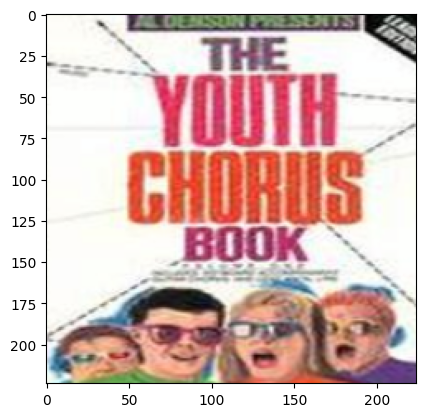

In [31]:
imshow(process_image(test_path+'/27/0001484524.jpg'));


In [32]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = torch.unsqueeze(torch.Tensor(process_image(image_path)),0)
    
    
    with torch.no_grad():
        
        model.to(device)
        
        model.eval()
        
        image = image.to(device)
        
        output = model.forward(image)

        result = torch.exp(output.cpu()).topk(topk)
    
    probs = result[0][0].numpy()
    
    indices = result[1][0].numpy() 
    
    idx_to_class = { v : k for k,v in model.class_to_idx.items()}

    classes = [idx_to_class[x] for x in indices]

    return probs, classes

In [33]:
# Predicting probabilites of classes

prob, classes =predict(test_path+'/27/0001484524.jpg',loaded_network)
print(prob,classes)

[0.2583776  0.16531178 0.14422095 0.06907666 0.05644017] ['26', '1', '13', '5', '27']


In [34]:
def display(img_path, probs,label_map):
    

    img_label = img_path.split('/')[-2]
    labels = [label_map[x].title() for x in classes]
    print(labels)
    fig, (i_plot, p_plot) = plt.subplots(nrows=2,ncols=1,figsize=(4,8))

    i_plot.axis('off')
    i_plot.set_title(label_map[img_label].title())
    i_plot.imshow(Image.open(img_path))



    ypos = np.arange(len(probs))
    p_plot.barh(ypos,probs)
    p_plot.set_yticks(ypos)
    p_plot.set_yticklabels(labels)
    p_plot.invert_yaxis()  

['Sports & Outdoors', 'Biographies & Memoirs', 'Humor & Entertainment', 'Comics & Graphic Novels', 'Teen & Young Adult']


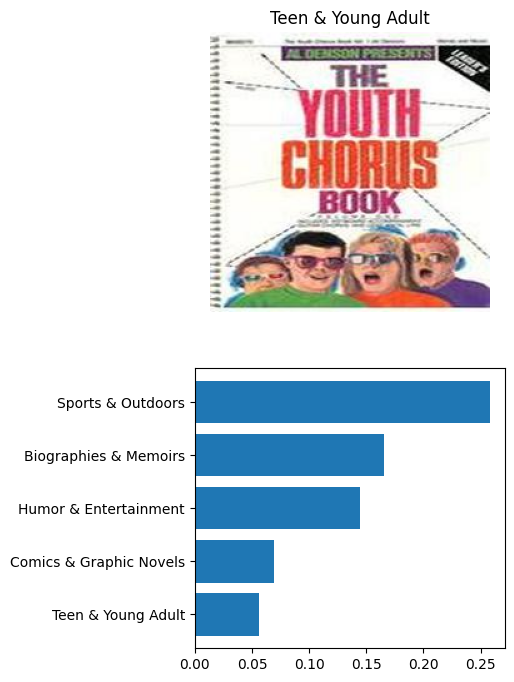

In [35]:
display(test_path+'/27/0001484524.jpg',prob,cat_to_name)


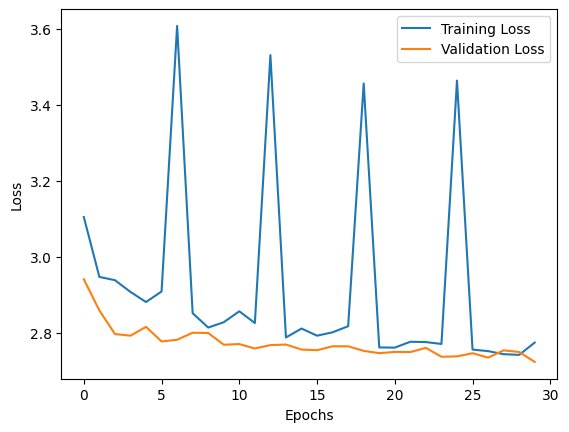

In [36]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(running,label='Training Loss')
plt.plot(valid,label='Validation Loss')
plt.legend()
plt.show()

In [37]:
# Test the model
apreds = []
alabels = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in testloader:
        alabels.append(labels)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        apreds.append(outputs.detach().cpu())
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 31.57504873294347 %


In [38]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [39]:
total_top1 = 0
total_top3 = 0
total_top5 = 0
for i in range(len(apreds)):
  top1, top3, top5 = accuracy(apreds[i], alabels[i], topk = (1, 3, 5))
  total_top1 += top1
  total_top3 += top3
  total_top5 += top5
print(f"Top 1 Accuracy is: {total_top1/len(apreds)}")
print(f"Top 3 Accuracy is: {total_top3/len(apreds)}")
print(f"Top 5 Accuracy is: {total_top5/len(apreds)}")


Top 1 Accuracy is: 31.598737716674805
Top 3 Accuracy is: 51.798240661621094
Top 5 Accuracy is: 63.60271072387695
